In [292]:
import serial
import plotly
#import matplotlib as plt
import sys
import visa
from LQCE.zvl13 import *
from LQCE.ncs513 import *
from LQCE.N5173B import *
from LQCE.awg33500 import *
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import time
import scipy.signal
import scipy.optimize
%matplotlib 
#%matplotlib inline


Using matplotlib backend: Qt5Agg


# __AWG Init cell__
## ch1 - pulse with offset
## ch2 - dc offset
## sync - trigger out for n5173b

In [286]:
def awg_init_burst_mode():  
    awg.set_modulation_source("INT")
    awg.set_waveform_type(1,"PULSe")
    awg.set_waveform_type(2,"DC")
    awg.set_voltage_offset(2, 0)
    awg.set_voltage_offset(1, 0.05)
    awg.set_pulse_width(1,1e-6)#set width 100ns
    awg.set_pulse_period(1,1e-4)#set period 1ms
    awg.set_pulse_both_edge(1, 20e-9)
    awg.set_sync_source("CH1")
    awg.set_sync_mode(1, "CARRier")
    awg.set_burst_state(1,"ON")
    awg.set_burst_mode(1, "TRIGgered")
    awg.set_burst_count(1, 10000)
    awg.set_burst_trigger_source(1, "BUS")
    awg.set_sync_output("ON")
    awg.set_output(1, "ON")
    awg.set_output(2, "ON")
def awg_init(mixer_calibration_result):  
    awg.set_modulation_source("INT")
    awg.set_waveform_type(1,"PULSe")
    awg.set_waveform_type(2,"DC")
    awg.set_voltage_offset(2, mixer_calibration_result[1])
    awg.set_voltage_offset(1, 0.05 + mixer_calibration_result[0])
    awg.set_voltage(1,100e-3)
    awg.set_pulse_width(1,1e-6)
    awg.set_pulse_period(1,1e-4)
    awg.set_pulse_both_edge(1, 20e-9)
    awg.set_sync_source("CH1")
    awg.set_sync_mode(1, "CARRier")
    awg.set_sync_output("ON")
    awg.set_output(1, "ON")
    awg.set_output(2, "ON")
def awg_base_init():  
    awg.set_waveform_type(1,"DC")
    awg.set_waveform_type(2,"DC")
    awg.set_voltage_offset(1, 0)
    awg.set_voltage_offset(2, 0)
    awg.set_sync_output("OFF")
    awg.set_output(1, "ON")
    awg.set_output(2, "ON")
def awg_set_voltage_with_offset(value, offset):
    awg.set_voltage_offset(1, offset[0] + value/2)
    awg.set_voltage(1, value)
def awg_set_delay(delay):
    awg.set_phase_units("SEC")
    awg.write("SOURce1:PHASe {}".format(-100e-9 - delay*1e-9))
    
#n5173b part    
def gen_init_pulse_mode(freq, pulse_start_len):
    gen.set_output_state("OFF")
    gen.set_frequency(freq)
    gen.set_alc_state("OFF")
    gen.set_modulation_state("ON")
    gen.set_pulse_out_state("ON")
    gen.set_power(-5)
    gen.set_trigger_source("EXTernal")
    gen.set_trigger_external_source("PULSe")
    gen.set_pulse_mode("PTRain")
    gen.set_pulse_train_ontime(pulse_start_len)
    gen.set_pulse_train_offtime(20e-9)
    gen.set_pulse_train_repetition(1)
    gen.set_pulse_train_trigger("TRIGgered")
    gen.set_pulse_internal_step_delay(10e-9)
    gen.set_pulse_internal_delay(0)
    gen.set_output_state("ON")

    
#mixer calibration part    
def find_minimum(x):
    awg.set_voltage_offset(2, x[1])
    awg.set_voltage_offset(1, x[0])
    time.sleep(0.1)
    nwa.trig_meas()
    temp_data = nwa.get_data(10)
    data_averaged = np.average(temp_data[0],0)
    #temp_slice = data_averaged[1]
    return (data_averaged[1])

def calibrate():
    nwa.set_standard_config({"power": 0,"nop":2, "cf_span":[7.055e9, 2], "bandwidth":100, "meas_counts":10})
    nwa.set_output_state("ON")
    awg_base_init()
    #gen.set_output_state("OFF")  
    awg.set_output(1, "ON")
    awg.set_output(2, "ON") 
    
    calibrate_res = scipy.optimize.minimize(find_minimum,(0.00,-0.00), method='Nelder-Mead', options = {"maxiter": 50, 'xtol': 1e-2, 'disp': True}, bounds = ((-0.1,0.1), (-0.1,0.1)))
    print(calibrate_res)
    return (calibrate_res.x, calibrate_res.fun)    
    

# __INIT__

In [170]:
nwa = zvl13("TCPIP0::192.168.1.51::INSTR")
awg = awg33500("TCPIP0::192.168.1.50::INSTR")
gen = N5173B_gen("TCPIP0::192.168.1.34::INSTR")
#ncs = Nsk_current_source("COM5")
#ncs.enable_channel(3)
#ncs.set_output_state(3,1)
#ncs.set_range(3,"1mA")
#ncs.set_current(3,105e-6)

In [181]:
gen.set_pulse_train_ontime(100e-9)
gen.set_power(-5)
gen.set_output_state("ON")
awg_set_delay(100)

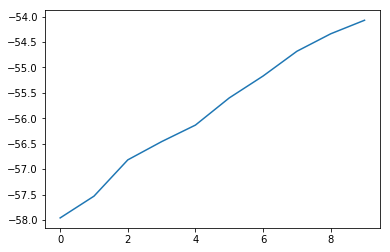

In [124]:
awg_init(cal_result[0])
nwa.set_standard_config({"power":0,"nop":2, "cf_span":[7.055e9, 2], "bandwidth":100, "meas_counts":10})
dt_sin = []
for i in range(10):
    awg_set_voltage_with_offset((i+1)*10e-3, cal_result[0])
    time.sleep(0.1)
    nwa.trig_meas()
    temp_data = nwa.get_data(10)
    data_sin = np.average(temp_data[0],0)
    dt_sin.append(data_sin[0])
plt.plot(dt_sin)

# __Mixer Calibration__

In [123]:
cal_result = calibrate()

(array([ 0.10434525, -0.02172289]), -85.39530067811566)


# __Decay__

In [314]:
# |DP\__delay(loop)__|RO|
awg_init(cal_result[0])
gen_init_pulse_mode(100e6, 20e-9)#at this moment gen wait a trigger to start pulse
awg_set_delay(20)#in ns| for ex. (100) = 100ns (with offset 100ns = 200ns)
nwa.set_standard_config({"power":0,"nop":2, "cf_span":[7.055e9, 2], "bandwidth":10, "meas_counts":1})

decay_step = 4

decay_data_result = []
decay_x_axis = []
plt.ion()
fig = plt.figure()

for i in range(11):
    awg_set_delay(20 + i*decay_step)
    time.sleep(0.5)
    nwa.trig_meas()
    temp_data = nwa.get_data(1)
    temp_dB = temp_data[0][0]
    decay_data_result.append(temp_dB[1])
    decay_x_axis.append(20 + i*decay_step)
    plt.ylabel("dB")
    plt.xlabel("delay, ns")
    plt.title("Decay")
    plt.plot(decay_x_axis, decay_data_result, 'ro')
    
    fig.canvas.draw()
    fig.canvas.flush_events()


In [327]:
gen.close()
nwa.close()
awg.close()

# __Rabi__
### _DP(in loop)__delay(fixed)__RO(fixed)_

In [326]:
awg_init(cal_result[0])
gen_init_pulse_mode(200e6, 20e-9)#at this moment gen wait a trigger to start pulse
awg_set_delay(20)#in ns| for ex. (100) = 100ns (with offset 100ns = 200ns)
nwa.set_standard_config({"power":0,"nop":2, "cf_span":[7.055e9, 2], "bandwidth":10, "meas_counts":1})

rabi_step = 4

decay_data_result = []
decay_x_axis = []
plt.ion()
fig = plt.figure()

for i in range(11):
    awg.set_sync_output("OFF")
    gen.set_output_state("OFF")
    time.sleep(1)
    gen.set_pulse_train_ontime(20e-9 + i*20e-9)
    awg_set_delay(20 + i*rabi_step)
    awg.set_sync_output("ON")
    gen.set_output_state("ON")
    time.sleep(1)
    nwa.trig_meas()
    temp_data = nwa.get_data(1)
    temp_dB = temp_data[0][0]
    decay_data_result.append(temp_dB[1])
    decay_x_axis.append(20 + i*decay_step)
    plt.ylabel("dB")
    plt.xlabel("dt width, ns")
    plt.title("Rabi")
    plt.plot(decay_x_axis, decay_data_result, 'ro')
    
    fig.canvas.draw()
    fig.canvas.flush_events()


In [343]:
for i in range(11):
    #print(20e-9 + i*20e-9)
    #print(format(20e-9 + i*20e-9, "5.3f"))
    print("{:.1e}".format(20e-9 + i*20e-9))

2.0e-08
4.0e-08
6.0e-08
8.0e-08
1.0e-07
1.2e-07
1.4e-07
1.6e-07
1.8e-07
2.0e-07
2.2e-07


# __FIT SIN(F * x) * exp(decay)__

[5.08334067 5.00065798]


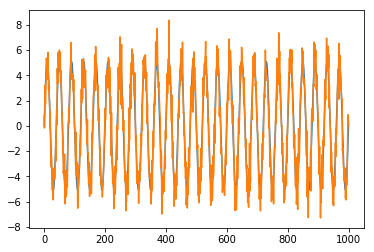

In [285]:

def fit_func(xi, ai, bi):
    return ai*np.sin(bi * xi)
def fit_decay_rabi(xi, ai, bi, decay):
    return ai*np.sin(bi * xi)*np.exp(decay)

x = np.linspace(0, 10*np.pi, 1000)

ydata = 5*np.sin(5*x) + np.random.normal(size=1000)    
xdata = np.linspace(0, 10*np.pi, 1000)   

params, params_covariance  = scipy.optimize.curve_fit(fit_func, xdata, ydata, p0 = [5, 5])

print(params)

plt.plot(fit_func(xdata, params[0], params[1]))
plt.plot(ydata)


In [ ]:
nwa.set_output_state("ON")
nwa.set_standard_config({"power":-50,"nop":101,"averages": 1, "cf_span":[2.5e9, 2e9], "bandwidth":10, "meas_counts":1})

ncs.enable_channel(1)
ncs.set_output_state(1,1)
ncs.set_range(1,"10mA")
ncs.set_current(1,0)
nwa.set_timeout(200000)


plt.ion()

fig = plt.figure()
z_upd = []

for i in range(10):
    ncs.set_current(1,i*1e-4)
    nwa.trig_meas()
    x_axis = nwa.get_X_axis_values()   
    data = nwa.get_data(int(nwa.get_meas_counts()))
    x_upd = x_axis#[]
    y_upd = []
    nx = 101#x_upd.shape[0]
    no_labels = 5
    step_x = int(nx/(no_labels -1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x_upd[::step_x]
    plt.yticks(x_positions, x_labels)
    
    z_upd.append(data[0][0])
    y_upd.append(i)
    plt.imshow(np.transpose(z_upd),interpolation='nearest', aspect='auto', cmap=cm.seismic, origin = 'lower')
    #nwa.set_timeout(1000)
    #plt.plot(x_axis, np.average(data[0],0))
    #line1.set_ydata(data[0][i][50])
    fig.canvas.draw()
    fig.canvas.flush_events()


In [11]:
from __future__ import division
from matplotlib.patches import Patch
from pylab import *


y = np.linspace(0,1e-3,5)
x = x_axis
X,Y = meshgrid(y, x)


Z = np.transpose(np.array(act_data))

pcolor(X, Y, Z, cmap=cm.RdBu, vmax=abs(Z).max(), vmin=-abs(Z).max())
colorbar()
#axis([-3,3,-3,3])

plt.ion()

    fig.canvas.draw()
    fig.canvas.flush_events()



In [74]:
import matplotlib.animation as animation


fig2 = plt.figure()
x = x_axis
y = [np.arange(3)]
base = np.array(act_data[0:3])
X,Y = meshgrid(x, y)
ims = []
plt.pcolormesh(X, Y, base)




In [4]:
x = np.arange(100)
y = np.arange(100)
temp = [[0]*len(x)]*len(y)
nrows, ncols = 100, 100
grid = temp #.reshape((nrows, ncols))

for i in range(len(x)):
    temp[i] = np.random.rand(100)
fig = plt.figure()
plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()),
           interpolation='nearest', aspect='equal', cmap=cm.jet)
plt.colorbar()

plt.ion()
x_upd = []
y_upd = np.array([])
z_upd = []

for i in range(10):    
    time.sleep(1)
    #z_upd.append([1,2,3,4])
    z_upd.append(np.random.rand(4))
    plt.imshow(np.transpose(z_upd),interpolation='nearest', aspect='auto', cmap=cm.RdBu)
    
    fig.canvas.draw()
    fig.canvas.flush_events()    



In [2]:
def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result


data_averaged = np.average(data,0)
peak_data = scipy.signal.find_peaks(data_averaged, height=4, distance=100)
print(peak_data[0])
print(x_axis[peak_data[0][0]])#,x_axis[peak_data[0][1]],x_axis[peak_data[0][2]], x_axis[peak_data[0][3]],x_axis[peak_data[0][4]],x_axis[peak_data[0][5]])
